![Cartoon of telecom customers](IMG_8811.png)


The telecommunications (telecom) sector in India is rapidly changing, with more and more telecom businesses being created and many customers deciding to switch between providers. "Churn" refers to the process where customers or subscribers stop using a company's services or products. Understanding the factors that influence keeping a customer as a client in predicting churn is crucial for telecom companies to enhance their service quality and customer satisfaction. As the data scientist on this project, you aim to explore the intricate dynamics of customer behavior and demographics in the Indian telecom sector in predicting customer churn, utilizing two comprehensive datasets from four major telecom partners: Airtel, Reliance Jio, Vodafone, and BSNL:

- `telecom_demographics.csv` contains information related to Indian customer demographics:

| Variable             | Description                                      |
|----------------------|--------------------------------------------------|
| `customer_id `         | Unique identifier for each customer.             |
| `telecom_partner `     | The telecom partner associated with the customer.|
| `gender `              | The gender of the customer.                      |
| `age `                 | The age of the customer.                         |
| `state`                | The Indian state in which the customer is located.|
| `city`                 | The city in which the customer is located.       |
| `pincode`              | The pincode of the customer's location.          |
| `registration_event` | When the customer registered with the telecom partner.|
| `num_dependents`      | The number of dependents (e.g., children) the customer has.|
| `estimated_salary`     | The customer's estimated salary.                 |

- `telecom_usage` contains information about the usage patterns of Indian customers:

| Variable   | Description                                                  |
|------------|--------------------------------------------------------------|
| `customer_id` | Unique identifier for each customer.                         |
| `calls_made` | The number of calls made by the customer.                    |
| `sms_sent`   | The number of SMS messages sent by the customer.             |
| `data_used`  | The amount of data used by the customer.                     |
| `churn`    | Binary variable indicating whether the customer has churned or not (1 = churned, 0 = not churned).|


In [2]:
# Importing libraries and methods/functions
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

## Data Validation

In [3]:
telecom_demo = pd.read_csv('telecom_demographics.csv')
print(telecom_demo.head())

   customer_id telecom_partner gender  age             state       city  \
0        15169          Airtel      F   26  Himachal Pradesh      Delhi   
1       149207          Airtel      F   74       Uttarakhand  Hyderabad   
2       148119          Airtel      F   54         Jharkhand    Chennai   
3       187288    Reliance Jio      M   29             Bihar  Hyderabad   
4        14016        Vodafone      M   45          Nagaland  Bangalore   

   pincode registration_event  num_dependents  estimated_salary  
0   667173         2020-03-16               4             85979  
1   313997         2022-01-16               0             69445  
2   549925         2022-01-11               2             75949  
3   230636         2022-07-26               3             34272  
4   188036         2020-03-11               4             34157  


In [4]:
telecom_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500 entries, 0 to 6499
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   customer_id         6500 non-null   int64 
 1   telecom_partner     6500 non-null   object
 2   gender              6500 non-null   object
 3   age                 6500 non-null   int64 
 4   state               6500 non-null   object
 5   city                6500 non-null   object
 6   pincode             6500 non-null   int64 
 7   registration_event  6500 non-null   object
 8   num_dependents      6500 non-null   int64 
 9   estimated_salary    6500 non-null   int64 
dtypes: int64(5), object(5)
memory usage: 507.9+ KB


In [5]:
telecom_usage = pd.read_csv('telecom_usage.csv')
print(telecom_usage.head())

   customer_id  calls_made  sms_sent  data_used  churn
0        15169          75        21       4532      1
1       149207          35        38        723      1
2       148119          70        47       4688      1
3       187288          95        32      10241      1
4        14016          66        23       5246      1


In [6]:
telecom_usage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500 entries, 0 to 6499
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   customer_id  6500 non-null   int64
 1   calls_made   6500 non-null   int64
 2   sms_sent     6500 non-null   int64
 3   data_used    6500 non-null   int64
 4   churn        6500 non-null   int64
dtypes: int64(5)
memory usage: 254.0 KB


In [7]:
churn_df = pd.merge(telecom_demo, telecom_usage, on='customer_id')
print(churn_df.head())

   customer_id telecom_partner gender  age             state       city  \
0        15169          Airtel      F   26  Himachal Pradesh      Delhi   
1       149207          Airtel      F   74       Uttarakhand  Hyderabad   
2       148119          Airtel      F   54         Jharkhand    Chennai   
3       187288    Reliance Jio      M   29             Bihar  Hyderabad   
4        14016        Vodafone      M   45          Nagaland  Bangalore   

   pincode registration_event  num_dependents  estimated_salary  calls_made  \
0   667173         2020-03-16               4             85979          75   
1   313997         2022-01-16               0             69445          35   
2   549925         2022-01-11               2             75949          70   
3   230636         2022-07-26               3             34272          95   
4   188036         2020-03-11               4             34157          66   

   sms_sent  data_used  churn  
0        21       4532      1  
1        3

In [8]:
# Handling estimated salary column
churn_df['estimated_salary'].describe()

count      6500.000000
mean      85529.193385
std       37545.639180
min       20001.000000
25%       52905.000000
50%       85286.500000
75%      118817.500000
max      149977.000000
Name: estimated_salary, dtype: float64

In [9]:
# grouping estimated salary into bins
bins = [0, 30000, 60000, 90000, 120000, 150000]
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

# Grouping estimated salary into categories
churn_df['salary_group'] = pd.cut(churn_df['estimated_salary'], bins=bins, labels=labels)

In [10]:
churn_df['salary_group'].value_counts().sort_index()

salary_group
Very Low      462
Low          1516
Medium       1519
High         1446
Very High    1557
Name: count, dtype: int64

In [11]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500 entries, 0 to 6499
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   customer_id         6500 non-null   int64   
 1   telecom_partner     6500 non-null   object  
 2   gender              6500 non-null   object  
 3   age                 6500 non-null   int64   
 4   state               6500 non-null   object  
 5   city                6500 non-null   object  
 6   pincode             6500 non-null   int64   
 7   registration_event  6500 non-null   object  
 8   num_dependents      6500 non-null   int64   
 9   estimated_salary    6500 non-null   int64   
 10  calls_made          6500 non-null   int64   
 11  sms_sent            6500 non-null   int64   
 12  data_used           6500 non-null   int64   
 13  churn               6500 non-null   int64   
 14  salary_group        6500 non-null   category
dtypes: category(1), int64(9), object(5)
me

In [12]:
# Identifying categorical variables
columns_to_convert = ['telecom_partner', 'gender', 'state', 'city', 'salary_group',]
churn_df[columns_to_convert] = churn_df[columns_to_convert].apply(lambda col: col.astype('category'))
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500 entries, 0 to 6499
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   customer_id         6500 non-null   int64   
 1   telecom_partner     6500 non-null   category
 2   gender              6500 non-null   category
 3   age                 6500 non-null   int64   
 4   state               6500 non-null   category
 5   city                6500 non-null   category
 6   pincode             6500 non-null   int64   
 7   registration_event  6500 non-null   object  
 8   num_dependents      6500 non-null   int64   
 9   estimated_salary    6500 non-null   int64   
 10  calls_made          6500 non-null   int64   
 11  sms_sent            6500 non-null   int64   
 12  data_used           6500 non-null   int64   
 13  churn               6500 non-null   int64   
 14  salary_group        6500 non-null   category
dtypes: category(5), int64(9), object(1)
me

In [13]:
#Coverting Date columns to datetime
churn_df['registration_event'] = pd.to_datetime(churn_df['registration_event'])
churn_df['registration_event']

0      2020-03-16
1      2022-01-16
2      2022-01-11
3      2022-07-26
4      2020-03-11
          ...    
6495   2021-01-29
6496   2022-01-03
6497   2020-07-21
6498   2020-11-21
6499   2020-10-29
Name: registration_event, Length: 6500, dtype: datetime64[ns]

In [14]:
#Extracting month from registration_event
churn_df['month'] = churn_df['registration_event'].dt.month
churn_df['month'] = churn_df['month'].astype('category')
churn_df['month'].value_counts().sort_index()

month
1     630
2     584
3     679
4     643
5     519
6     509
7     491
8     481
9     486
10    532
11    459
12    487
Name: count, dtype: int64

In [15]:
# Identifying the target variable
churn_df['churn'].value_counts()

churn
0    5197
1    1303
Name: count, dtype: int64

In [16]:
#Renameing the target variable
# Mapping dictionary
rename_map = {1: 'Churned', 0: 'Not Churned'}

# Rename values
churn_df['churn'] = churn_df['churn'].replace(rename_map)

In [17]:
churn_df['churn'].astype('category')
churn_df['churn'].value_counts()

churn
Not Churned    5197
Churned        1303
Name: count, dtype: int64

In [18]:
churn_df[['calls_made', 'sms_sent','data_used','num_dependents', 'age']].describe()

,calls_made,sms_sent,data_used,num_dependents,age
count,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000
mean,49.789538,24.257846,5000.956308,1.982308,46.108615
std,29.799221,14.650736,2940.611928,1.404659,16.443712
min,-10.000000,-5.000000,-969.000000,0.000000,18.000000
25%,25.000000,12.000000,2493.750000,1.000000,32.000000
50%,50.000000,25.000000,4975.500000,2.000000,46.000000
75%,75.000000,37.000000,7504.250000,3.000000,60.000000
max,108.000000,53.000000,10919.000000,4.000000,74.000000


In [19]:
#Does not make sense to have negative values for these columns
churn_df[['calls_made', 'sms_sent','data_used','num_dependents']] = churn_df[['calls_made', 'sms_sent','data_used','num_dependents']].apply(np.abs)
churn_df[['calls_made', 'sms_sent','data_used','num_dependents']].describe()

,calls_made,sms_sent,data_used,num_dependents
count,6500.000000,6500.000000,6500.000000,6500.000000
mean,50.004923,24.372615,5017.830769,1.982308
std,29.436305,14.458974,2911.719571,1.404659
min,0.000000,0.000000,4.000000,0.000000
25%,25.000000,12.000000,2493.750000,1.000000
50%,50.000000,25.000000,4975.500000,2.000000
75%,75.000000,37.000000,7504.250000,3.000000
max,108.000000,53.000000,10919.000000,4.000000


In [20]:
churn_df.drop(columns=['estimated_salary', 'registration_event', 'customer_id', 'pincode'], inplace=True)

In [21]:
churn_df.head(10)

,telecom_partner,gender,age,state,city,num_dependents,calls_made,sms_sent,data_used,churn,salary_group,month
0,Airtel,F,26,Himachal Pradesh,Delhi,4,75,21,4532,Churned,Medium,3
1,Airtel,F,74,Uttarakhand,Hyderabad,0,35,38,723,Churned,Medium,1
2,Airtel,F,54,Jharkhand,Chennai,2,70,47,4688,Churned,Medium,1
3,Reliance Jio,M,29,Bihar,Hyderabad,3,95,32,10241,Churned,Low,7
4,Vodafone,M,45,Nagaland,Bangalore,4,66,23,5246,Churned,Low,3
5,BSNL,M,69,West Bengal,Delhi,4,65,18,5961,Churned,High,2
6,Reliance Jio,M,34,Punjab,Chennai,3,16,17,5732,Churned,Very High,3
7,BSNL,F,55,Arunachal Pradesh,Chennai,2,45,2,531,Churned,Low,8
8,Airtel,F,50,Maharashtra,Hyderabad,3,4,51,8292,Churned,Low,8
9,BSNL,M,38,Odisha,Kolkata,4,22,36,6726,Churned,High,2


## Explanatory Analysis

### Target Variable

<Axes: xlabel='churn', ylabel='count'>

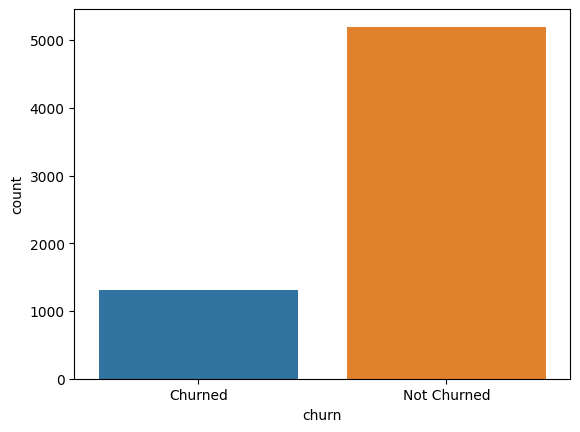

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='churn', data=churn_df, hue ='churn')

In [23]:
# Determining Churn Rate
churn_rate = round(churn_df['churn'].value_counts(normalize=True) * 100, 1)
print(f"The Churn Rate is {churn_rate.iloc[1]:.1f}%")

The Churn Rate is 20.0%


### Numeric variables

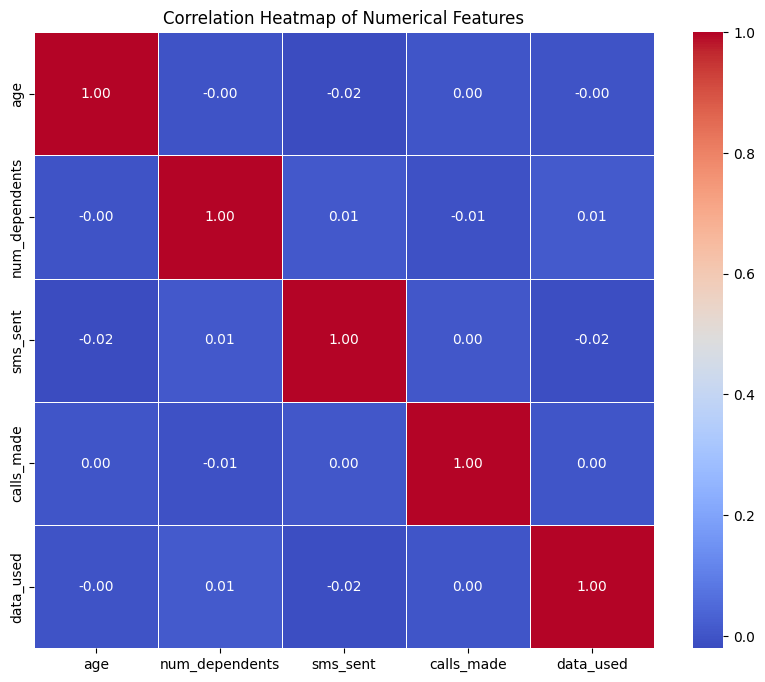

In [24]:
# Selecting only the numerical features
numerical_features = churn_df[['age', 'num_dependents', 'sms_sent', 'calls_made', 'data_used' ]]

# Calculating the correlation matrix
correlation_matrix = numerical_features.corr()

# Creating a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

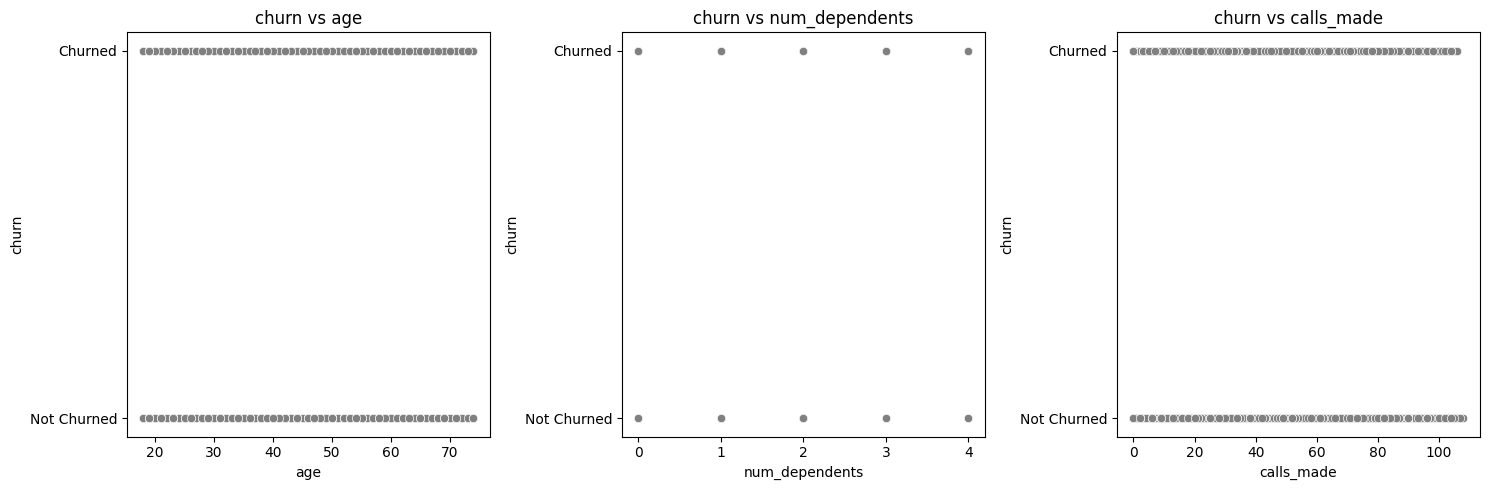

In [25]:
fig, axes = plt.subplots(1,3,figsize=(15,5))

sns.scatterplot(y=churn_df['churn'], x=churn_df['age'], color='gray', ax=axes[0]).set(title='churn vs age')
sns.scatterplot(y=churn_df['churn'], x=churn_df['num_dependents'], color='gray', ax=axes[1]).set(title='churn vs num_dependents')
sns.scatterplot(y=churn_df['churn'], x=churn_df['calls_made'], color='gray', ax=axes[2]).set(title='churn vs calls_made')

plt.tight_layout()
plt.show()

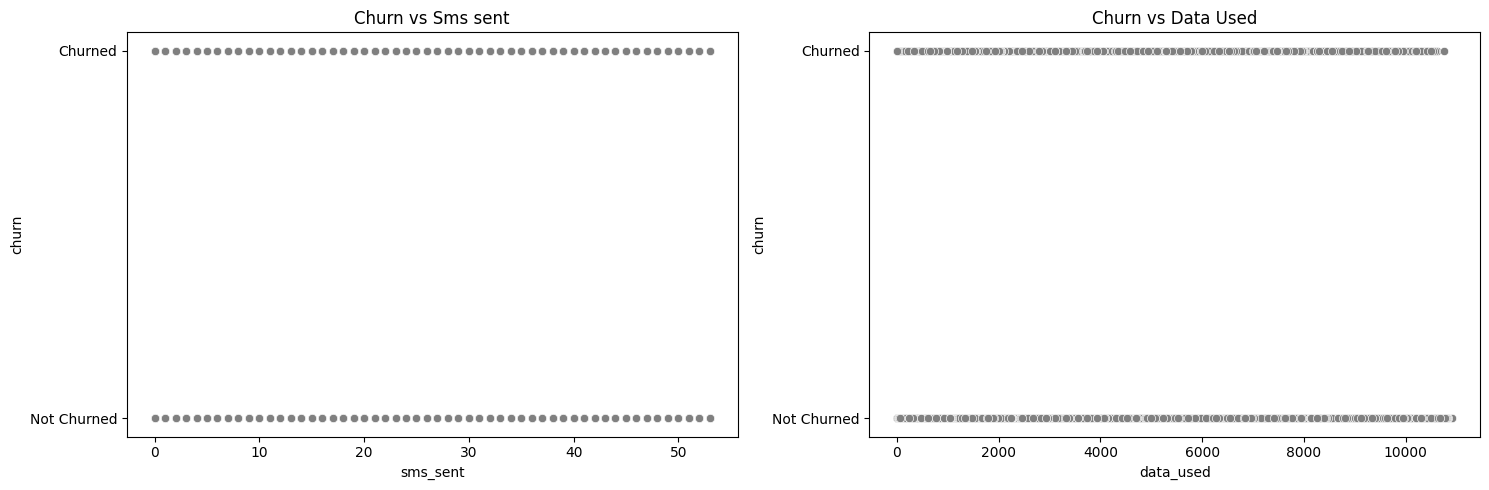

In [26]:
fig, axes = plt.subplots(1,2,figsize=(15,5))

sns.scatterplot(y=churn_df['churn'], x=churn_df['sms_sent'], color='gray', ax=axes[0]).set(title='Churn vs Sms sent')
sns.scatterplot(y=churn_df['churn'], x=churn_df['data_used'], color='gray', ax=axes[1]).set(title='Churn vs Data Used')

plt.tight_layout()
plt.show()

<Axes: xlabel='age', ylabel='Count'>

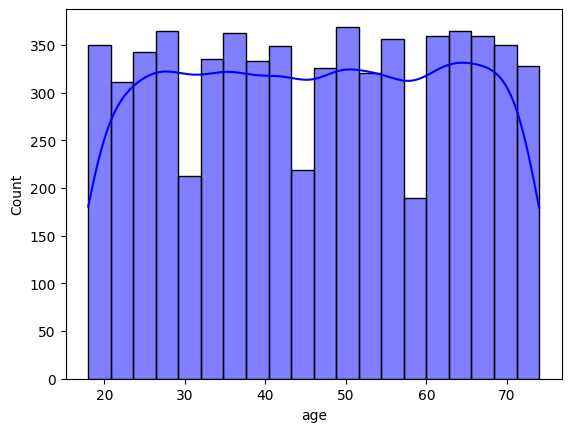

In [34]:
sns.histplot(churn_df['age'], bins=20, kde=True, color='blue')

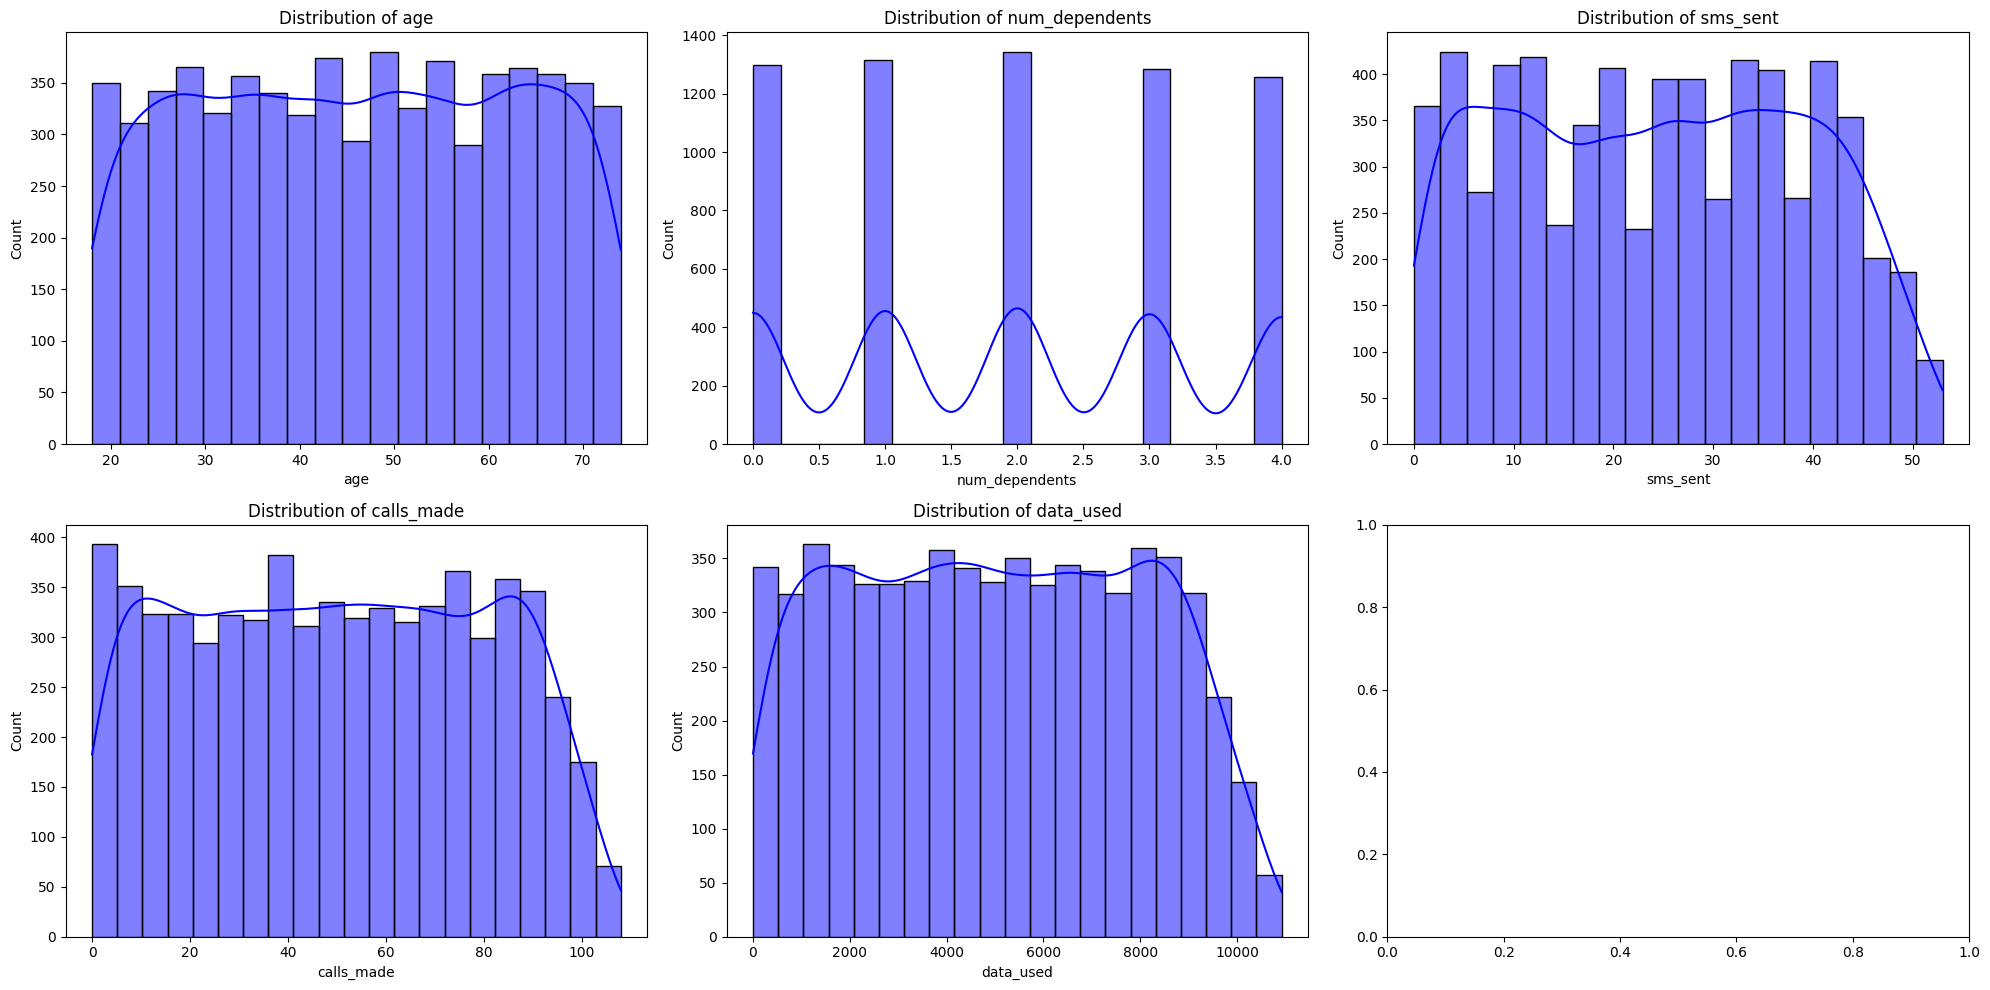

In [36]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
axes = axes.flatten()

for i, column in enumerate(numerical_features.columns):
    sns.histplot(data=churn_df, x=column, kde=True, color='blue', ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

### Categorical Variables

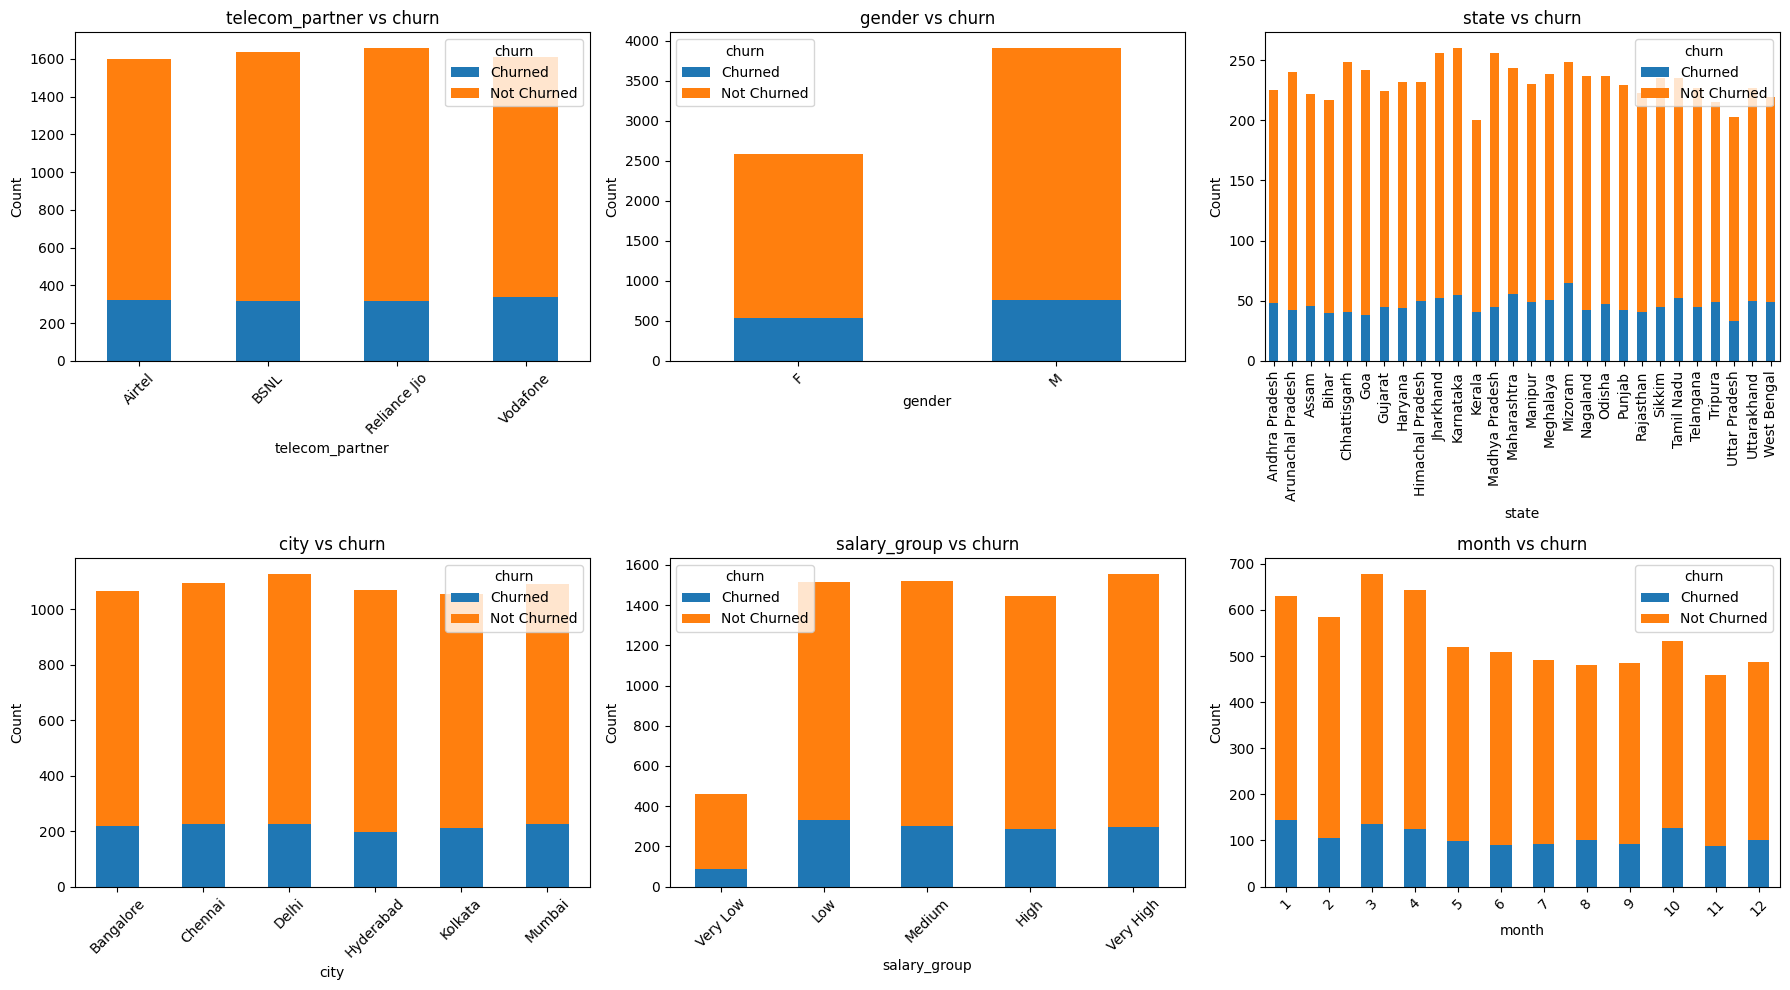

In [28]:
categorical_cols = ['telecom_partner', 'gender', 'state', 'city', 'salary_group', 'month']
target = 'churn'

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, var in enumerate(categorical_cols):
    # Create crosstab of churn counts
    counts = pd.crosstab(churn_df[var], churn_df[target])

    # Plot stacked bars
    counts.plot(kind='bar', stacked=True, ax=axes[i])

    axes[i].set_title(f'{var} vs churn')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Count')
    if var == 'state':
        axes[i].tick_params(axis='x', rotation=90)
    else:
        axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()